<center>
    <h1>Verbal Explanation of Spatial Temporal GNNs for Traffic Forecasting</h1>
    <h2>Building a STGNN for the Metr-LA dataset</h2>
    <h3>Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it - rspolaor@tudelft.nl</h4>
</center>

---

In this notebook the *Spatial Temporal Graph Neural Network (STGNN)* proposed in the paper *Traffic Flow Prediction via Spatial Temporal Graph Neural Network* <a name="cite_paper"></a>[<sup>[1]</sup>](#note_paper) is built, trained and evaluated on the *Metr-LA* dataset.

Firstly, the data is pre-processed for the task and its distribution is analysed. Next, the model is built and it is trained on the processed data. Finally the model is tested on a subset of the data not used in the training procedure.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

The dataset used in the work is the one presented in the experiment providing the original benchmark, which code is available at the following link: https://github.com/liyaguang/DCRNN.

The architecture of the model proposed for the task takes inspiration from the one provided at the following link: https://github.com/LMissher/STGNN. although it presents certain architectural differences.

---
<small>

<a name="note_paper"></a>[1] Xiaoyang Wang et al. “Traffic Flow Prediction via Spatial Temporal Graph Neural Network”. In:
*Proceedings of The Web Conference 2020*. WWW ’20. Taipei, Taiwan: Association for Computing
Machinery, 2020, pp. 1082–1092. ISBN: 9781450370233. DOI: 10.1145/3366423.3380186. URL:
https://doi.org/10.1145/3366423.3380186.

</small>

In [94]:
import sys
import os

# Set the main path in the root folder of the project.
sys.path.append(os.path.join('..'))

In [95]:
# Settings for autoreloading.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
from src.utils.seed import set_random_seed

# Set the random seed for deterministic operations.
SEED = 42
set_random_seed(SEED)

In [97]:
import torch

# Set the device for training and querying the model.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The selected device is: "{DEVICE}"')

The selected device is: "cuda"


DEPENDENCY Pytables

# 1 Data Preparation
The ***Metr-LA*** dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). A selection of $207$ sensors along with a 4 month span of data ranging from Mar $1^{st}$ $2012$ to Jun $30^{th}$ $2012$ is used in the experiment.

The traffic speed readings are aggregated in $5$ minutes windows.

The total number of observed traffic data points is $6,519,002$.

In [98]:
# Set the base data directory.
BASE_DATA_DIR = os.path.join('..', 'data', 'metr-la')

## 1.1 Dataset Extraction and Preparation
Firstly, the dataset illustrating the speed of the nodes at different timestamps is extracted along with the adjacency matrix containing the spatial correlation among the different nodes.

Next, the time information is encoded and integrated in the dataset containing the node values in order to guarantee its format is suitable for the model operations.

---
*Note: In order to obtain comparable results for the evaluation task, the speed information and the adjacency matrix computed distances consider the original metrics of the experiment (miles/hour and miles respectively).*

In [99]:
# Set the base data directory.
BASE_DATA_DIR = os.path.join('..', 'data', 'metr-la')

The obtained data has the following structure:
* The node values dataset is in the form $\mathbb{R}^{T \times N \times F}$.
* The adjacency matrix is in the form $\mathbb{R}^{N \times N}$.

Where $T$ is the number of timestamps, $N$ is the number of nodes and $F$ the number of features.

In this experiment the feature used for the *Metr-LA* dataset are in the order:
* Speed in miles/hour observed by the node at a certain timestamp.
* The encoded hour of the day of the observed speed.
* The encoded minute of the our of the observed speed.

In [100]:
from src.data.data_extraction import get_node_values_dataframe

# Get the dataframe containing the node values at different timestamps.
node_values_df = get_node_values_dataframe(
    os.path.join(BASE_DATA_DIR, 'metr-la.h5'), turn_in_kmph=False)

In [101]:
from src.data.data_processing import get_node_values_numpy_matrix

# Set the methods in which the time is aggregated and encoded
TIME_AGGREGATIONS = [ 'time_of_day', 'day_of_week' ]

# Get the numpy matrix encoding the speed of the nodes and time
# information about the hour of the day and the minute of the hour.
node_values = get_node_values_numpy_matrix(
    node_values_df, time_aggregations=TIME_AGGREGATIONS)

In [102]:
# print(node_values[..., 5][2])

In [103]:
print('Shape of the node value matrix:', node_values.shape)

Shape of the node value matrix: (34272, 207, 9)


Finally, the data is divided into train, validation and test datasets which will be structured in other sections in order to meet the problem requisites.

The adjacency matrix is built by exploiting the pairwise road network distances between sensors through a thresholded Gaussian kernel.

$$
W_{ij} = \begin{cases}
\text{exp} \left ( - \frac{\text{dist}(v_i - v_j)^2}{\sigma^2} \right ) & \text{if} \ \leq k \\
0 & \text{otherwise}\\
\end{cases}
$$

Where $W_{ij}$ represents the edge weight between sensor $v_i$ and sensor $v_j$, $\text{dist}(v_i - v_j)$ denotes the road network distance from sensor $v_i$ to sensor $v_j$ . $\sigma$ is the standard deviation of distances and $k$ ($0.1$ in the original experiment) is the threshold.

In [104]:
from src.data.data_extraction import get_adjacency_matrix

# Get the adjacency matrix
adj_matrix_structure = get_adjacency_matrix(
    os.path.join(BASE_DATA_DIR, 'adj_mx_metr_la.pkl'))

# Get the header of the adjacency matrix and the matrix itself.
header, _, adj_matrix = adj_matrix_structure

In [105]:
# Assert that the adjacency matrix header nodes order corresponds to
# the order of the columns node header of the node values dataframe.
assert all(header == node_values_df.columns.values), \
'The columns of the node values dataframe are not ordered in the ' +\
'same fashion as the adjacency matrix header.'

In [106]:
print('Shape of the adjacency matrix:', adj_matrix.shape)

Shape of the adjacency matrix: (207, 207)


The dataset is split in *train*, *validation* and *test*, following the ratios $0.7$ $0.1$ and $0.2$ respectively.

In [107]:
from src.data.dataset_builder import train_test_val_split

# Split the dataset in train, validation and test.
train_dataset, val_dataset, test_dataset = train_test_val_split(
    node_values, test_size=.2, val_size=.1)

## 1.2 Data Pre-Processing
In this section the data is preprocessed in order to better fit the model structure.

The data standardization procedure is explained, and the datasets are divided in input data and ground truth data for the self-supervised regression task through the use of a sliding window.

First of all, a `scaler` is created to apply *Standard Scaling* to the data. This procedure leads the model to better performances.

Given an instance $x$ and considering that a feature of $x$ is denoted as $x_f$, its processed version $x'_f$ is obtained as:
$$ \forall \ f \ \text{of} \ x, \ x'_f = \frac{x_f - \mu_f}{\sigma_f}$$
Where $\mu_f$ is the mean of the feature $f$ and $\sigma_f$ its standard deviation.

The mean and standard deviation are estimated on the data that is used for training the model.

In [108]:
from src.data.data_processing import Scaler

# Fit the standard scaler with the train_dataset values.
scaler = Scaler(torch.tensor(train_dataset, dtype=torch.float32),
                has_day_of_week=True)

In [109]:
import pickle

with open(os.path.join(BASE_DATA_DIR, 'processed', 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

In [110]:
print('The scaler mean values:', scaler.mean.cpu().numpy())
print('The scaler standard deviation values:', scaler.std.cpu().numpy())

The scaler mean values: [54.401062    0.49733332  0.          0.          0.          0.
  0.          0.          0.        ]
The scaler standard deviation values: [19.416021  0.28861   1.        1.        1.        1.        1.
  1.        1.      ]


The statistics of the original training data are observed.

We can see that in the original data no feature has mean in $0$ and standard deviation in $1$ and it is hence no normalized. By observing the distribution of the features, it is clear how the `speed` feature presents a left skewed normal distribution. This is expected, as speed in highways tend to be closer to high values than to lower speeds. The high peak on $0$ is due to the large amount of missing values in the dataset.

The features encoding time present a uniform distribution. This is also an expected behavior as the train dataset covers a large period of time and present a timestamp every $5$ minutes without skipping any specific day or hour of the day.

In [111]:
from src.data.data_analysis import get_node_values_statistics_dataframe

statistics_df = get_node_values_statistics_dataframe(
    train_dataset, feature_names=['speed', 'time of the day',
                                  'day of the week'],
    has_day_of_the_week=True)

In [112]:
statistics_df.describe()

,speed,time of the day,day of the week
count,5.107725e+06,5.107725e+06,5.107725e+06
mean,5.440107e+01,4.973333e-01,3.007903e+00
std,1.941602e+01,2.886100e-01,1.982308e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.400000e+01,2.466991e-01,1.000000e+00
50%,6.250000e+01,4.968728e-01,3.000000e+00
75%,6.625000e+01,7.470466e-01,5.000000e+00
max,7.000000e+01,9.972203e-01,6.000000e+00


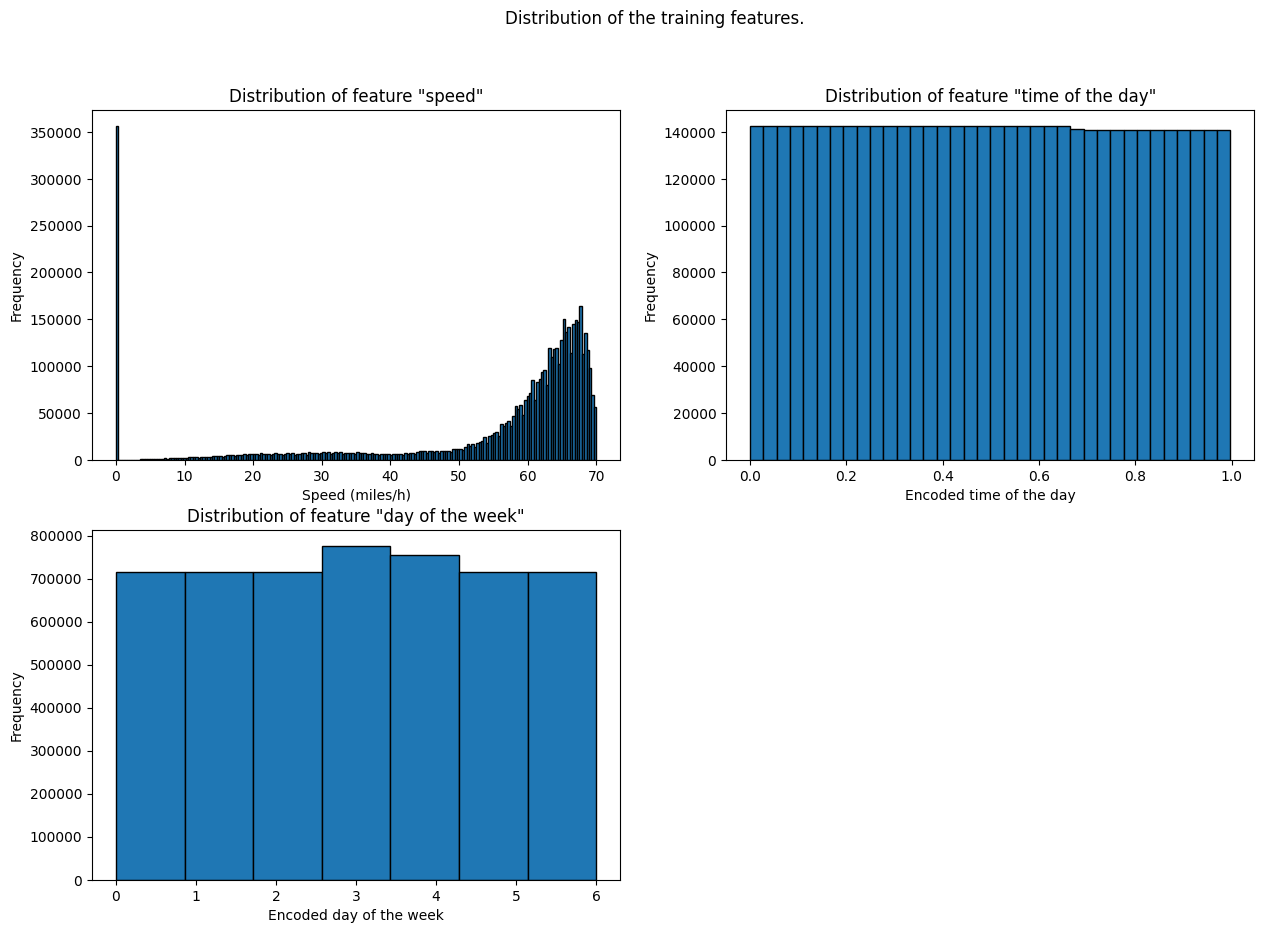

In [113]:
from src.data.data_analysis import plot_features_distribution

plot_features_distribution(
    statistics_df, bins=[200, 24 + 60 // 5, 7], 
    x_labels=['Speed (miles/h)', 'Encoded time of the day',
              'Encoded day of the week'],
    title='Distribution of the training features.')

In [114]:
# Scale the train dataset through standard scaling.
scaled_train_dataset = scaler.scale(
    torch.tensor(train_dataset, dtype=torch.float32))

The statistics of the scaled training data are observed.

The distributions are the same as the ones present in the un-scaled dataset, although we can observe that every variable has mean in $0$ and standard deviation in $1$ and it is thus normalized.

In [115]:
from src.data.data_analysis import get_node_values_statistics_dataframe

statistics_df = get_node_values_statistics_dataframe(
    scaled_train_dataset, feature_names=['speed', 'time of the day',
                                         'day of the week'],
    has_day_of_the_week=True)

In [116]:
statistics_df.describe()

,speed,time of the day,day of the week
count,5.107725e+06,5.107725e+06,5.107725e+06
mean,4.333645e-07,-7.225194e-08,3.007903e+00
std,1.000000e+00,1.000000e+00,1.982308e+00
min,-2.801865e+00,-1.723202e+00,0.000000e+00
25%,-2.065624e-02,-8.684183e-01,1.000000e+00
50%,4.171265e-01,-1.595494e-03,3.000000e+00
75%,6.102660e-01,8.652273e-01,5.000000e+00
max,8.034055e-01,1.732050e+00,6.000000e+00


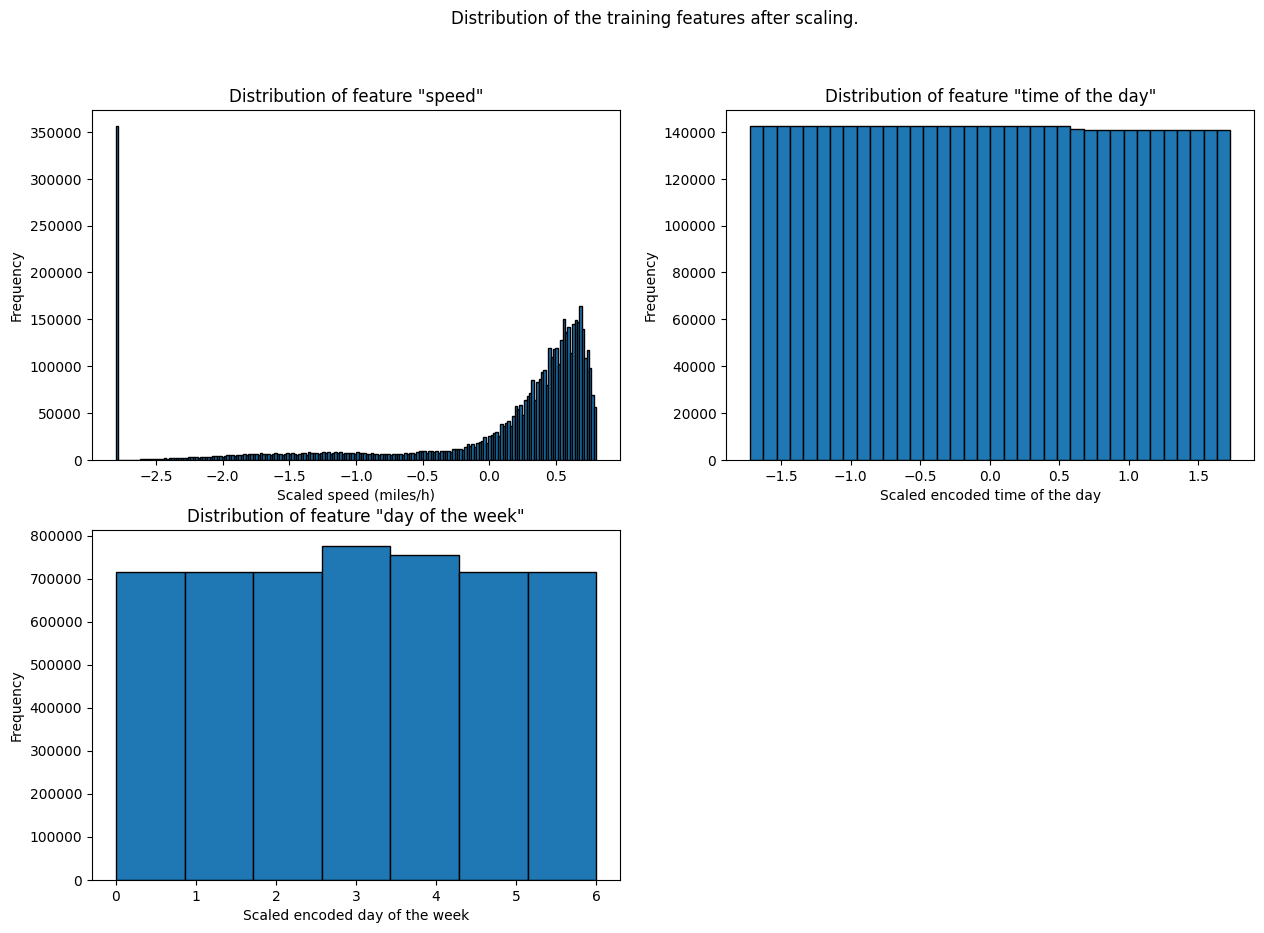

In [117]:
from src.data.data_analysis import plot_features_distribution

plot_features_distribution(
    statistics_df, bins=[200, 24 + 60 // 5, 7], 
    x_labels=['Scaled speed (miles/h)', 'Scaled encoded time of the day',
              'Scaled encoded day of the week'],
    title='Distribution of the training features after scaling.')

Next, a sliding window of size $(T_{in} + T_{out})$ is applied to each dataset, in order to obtain a self-supervised version of it, where in each window:
* The first $T_{in}$ elements are part of the input variables.
* The last $T_{out}$ elements are part of the ground truth.

For the experiment, both $T_{in}$ and $T_{out}$ are set to $12$

In [118]:
# Set the number of input and output timesteps.
N_IN_TIMESTEPS = 12
N_OUT_TIMESTEPS = 12

In [119]:
from src.data.data_processing import get_dataset_by_sliding_window

# Get self-supervised training validation and test sets.
x_train, y_train = get_dataset_by_sliding_window(
    train_dataset, x_stepsize=N_IN_TIMESTEPS, y_stepsize=N_OUT_TIMESTEPS)
x_val, y_val = get_dataset_by_sliding_window(
    val_dataset, x_stepsize=N_IN_TIMESTEPS, y_stepsize=N_OUT_TIMESTEPS)
x_test, y_test = get_dataset_by_sliding_window(
    test_dataset, x_stepsize=N_IN_TIMESTEPS, y_stepsize=N_OUT_TIMESTEPS)

In [120]:
print('Train dataset shapes:', x_train.shape, y_train.shape)
print('Validation dataset shapes:', x_val.shape, y_val.shape)
print('Test dataset shapes:', x_test.shape, y_test.shape)

Train dataset shapes: (1028, 12, 207, 9) (1028, 12, 207, 9)
Validation dataset shapes: (114, 12, 207, 9) (114, 12, 207, 9)
Test dataset shapes: (285, 12, 207, 9) (285, 12, 207, 9)


The time encoding features are removed from the ground truth data, as we are interested in predicting solely the speed value.

Thus the resulting datasets have the shape:
* $x \in \mathbb{R}^{T \times N \times (1 + F)}$
* $y \in \mathbb{R}^{T \times N \times 1}$

Where $x$ is the input data and $y$ the ground truth of the train, validation or test dataset. $T$ corresponds to the number of timesteps, $N$ to the number of nodes and $F$ indicates the amount of features that represent an encoding of the time steps.

In [121]:
# Remove the time encoding features from the ground truth.
y_train = y_train[..., :1]
y_val = y_val[..., :1]
y_test = y_test[..., :1]

In [123]:
print('Adjusted train dataset shapes:', x_train.shape, y_train.shape)
print('Adjusted validation dataset shapes:', x_val.shape, y_val.shape)
print('Adjusted test dataset shapes:', x_test.shape, y_test.shape)

Adjusted train dataset shapes: (1028, 12, 207, 9) (1028, 12, 207, 1)
Adjusted validation dataset shapes: (114, 12, 207, 9) (114, 12, 207, 1)
Adjusted test dataset shapes: (285, 12, 207, 9) (285, 12, 207, 1)


In [ ]:
from numpy import save

# Save the processed datasets.
save(os.path.join(BASE_DATA_DIR, 'processed', 'x_train.npy'), x_train)
save(os.path.join(BASE_DATA_DIR, 'processed', 'y_train.npy'), y_train)
save(os.path.join(BASE_DATA_DIR, 'processed', 'x_val.npy'), x_val)
save(os.path.join(BASE_DATA_DIR, 'processed', 'y_val.npy'), y_val)
save(os.path.join(BASE_DATA_DIR, 'processed', 'x_test.npy'), x_test)
save(os.path.join(BASE_DATA_DIR, 'processed', 'y_test.npy'), y_test)

# 2 Model definition and training procedure
In this section the model is defined and the training procedure is performed.

## 2.1 Model definition
The *Spatial Temporal Graph Neural Network* model is created. 

Its aim is to predict future traffic speed for each node of the graph according to historical speed information.
In particular, it predicts the next $T_{out}$ consecutive time representations of the graph with respect to the previous consecutive $T_{in}$ historical representations of the graph.

The model architecture consists in:
* An encoder that extracts hidden features from the input sequence of graphs.
* A series of *Spatial Graph Neural Network (S-GNN)* blocks, that extract information by modeling the spatial structure of each input instance of the graph with respect to the feature information. Furthermore, the adjacency matrix is used to help in the task.
* A series of *Gated Recurrent Units (GRU)* blocks to extract information about the temporal realtion among successive time steps of the input graphs. The resulting output of a *GRU* block is passed as the hidden input state of the next *GRU* block and processed along with the next time step of the graph. The output of each *GRU* block is processed through a *S-GNN* block before being given to the next *GRU* block.
* A *Transformer* block performing *Multi-Head Attention* in order to compute the global temporal relation among each time step. The outputs of the *GRU* are stacked together and concatenated with their *positional encoding*.
* A *multi layer* regression head to infer the speed of the output $T_{out}$ sequences.
<center>

![](../images/stgnn.png)

</center>

In [84]:
from src.spatial_temporal_gnn.model import SpatialTemporalGNN

model = SpatialTemporalGNN(9, 1, N_IN_TIMESTEPS, N_OUT_TIMESTEPS, adj_matrix,
                           DEVICE, 64)

In [85]:
from torchinfo import summary

print(summary(model, input_size=(64, *x_train.shape[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
SpatialTemporalGNN                       [64, 12, 207, 1]          --
├─Linear: 1-1                            [64, 12, 207, 64]         576
├─ModuleList: 1-34                       --                        (recursive)
│    └─S_GNN: 2-1                        [64, 207, 64]             --
│    │    └─Sequential: 3-1              [64, 207, 32]             6,144
│    │    └─Linear: 3-2                  [64, 207, 64]             4,096
├─ModuleList: 1-36                       --                        (recursive)
│    └─GRU: 2-2                          [64, 207, 64]             --
│    │    └─Linear: 3-3                  [64, 207, 64]             4,096
│    │    └─Linear: 3-4                  [64, 207, 64]             4,096
│    │    └─Linear: 3-5                  [64, 207, 64]             4,096
│    │    └─Linear: 3-6                  [64, 207, 64]             4,096
│    │    └─Linear: 3-7                  [64, 20

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


## 2.2 Training procedure
In this section the training of the model is performed. In addition, the train validation and test dataloaders are built and the important parameters and training utilities are set.

The train, validation and test dataloaders are built. Solely the data of the train dataloader is shuffled, in order for the model to overfit less, guaranteeing a more generalized training procedure.

In [86]:
from src.data.dataloaders import get_dataloader

train_dataloader = get_dataloader(x_train, y_train, batch_size=64,
                                  shuffle=True)
val_dataloader = get_dataloader(x_val, y_val, batch_size=64,
                                shuffle=False)
test_dataloader = get_dataloader(x_test, y_test, batch_size=64,
                                 shuffle=False)

The training utilities and parameters are assigned.
* `Adam` is used as an optimizer with learning rate $1e-3$ and weight decay $2e-6$.
* A checkpoint monitor is initialized to control the performances of the model on the validation set, by saving the best resulting weights which consist in the minimal error computed as the sum of the *Mean Absolute Error (MAE)*, the *Root Mean Squared Error (RMSE)* and the *Mean Absolute Percentage Error (MAPE)*.
* The number of *epochs* is set to $200$.

In [87]:
from src.spatial_temporal_gnn.training import Checkpoint

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=2e-6)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=.1, patience=10, verbose=False,
    threshold=.001, threshold_mode='rel', cooldown=0, min_lr=1e-3, eps=1e-08)

checkpoint_file_path = os.path.join('..', 'models', 'checkpoints',
                                    'st_gnn_metr_la.pth')
checkpoint = Checkpoint(checkpoint_file_path)

EPOCHS = 200

The training procedure is performed. The loss criterion is the *Mean Absolute Error (MAE)* computed on the unscaled speed predictins and ground truths.

Even the *Root Mean Squared Error (RMSE)* and the *Mean Absolute Percentage Error (MAPE)* are tracked which respect to the train and validation prediction performances.

The model is trained on scaled data and evaluated on unscaled data. The reason behind this decision is found in the increased performance of the model under this situation. Furthermore, the computation of the loss function on unscaled data consists in a more severe error penality and a more faithful comparison to the results of the original experiment.

In [88]:
from src.spatial_temporal_gnn.training import train

history = train(model, optimizer, train_dataloader, val_dataloader, scaler,
                EPOCHS, DEVICE, checkpoint=checkpoint, 
                lr_scheduler=lr_scheduler, reload_best_weights=True)

Epoch 1/200
[17/17] - 4s - train: { MAE (loss): 8.14 - RMSE: 13.1 - MAPE: 26.2% } - val: { MAE: 6.82 - RMSE: 11.8 - MAPE: 22.8% } - lr: 0.001 - weight decay: 2e-06
Epoch 2/200
[17/17] - 4s - train: { MAE (loss): 6.51 - RMSE: 11.4 - MAPE: 22.1% } - val: { MAE: 5.51 - RMSE: 9.83 - MAPE: 16.6% } - lr: 0.001 - weight decay: 2e-06
Epoch 3/200
[17/17] - 4s - train: { MAE (loss): 5.22 - RMSE: 9.43 - MAPE: 15.3% } - val: { MAE: 5.06 - RMSE: 9.61 - MAPE: 13.7% } - lr: 0.001 - weight decay: 2e-06
Epoch 4/200
[17/17] - 4s - train: { MAE (loss): 4.9 - RMSE: 9.13 - MAPE: 14.1% } - val: { MAE: 4.49 - RMSE: 8.98 - MAPE: 11.9% } - lr: 0.001 - weight decay: 2e-06
Epoch 5/200
[17/17] - 4s - train: { MAE (loss): 4.41 - RMSE: 8.38 - MAPE: 12.6% } - val: { MAE: 4.28 - RMSE: 8.49 - MAPE: 11.7% } - lr: 0.001 - weight decay: 2e-06
Epoch 6/200
[17/17] - 4s - train: { MAE (loss): 4.23 - RMSE: 8.36 - MAPE: 11.9% } - val: { MAE: 4.02 - RMSE: 8.19 - MAPE: 10.9% } - lr: 0.001 - weight decay: 2e-06
Epoch 7/200
[17/1

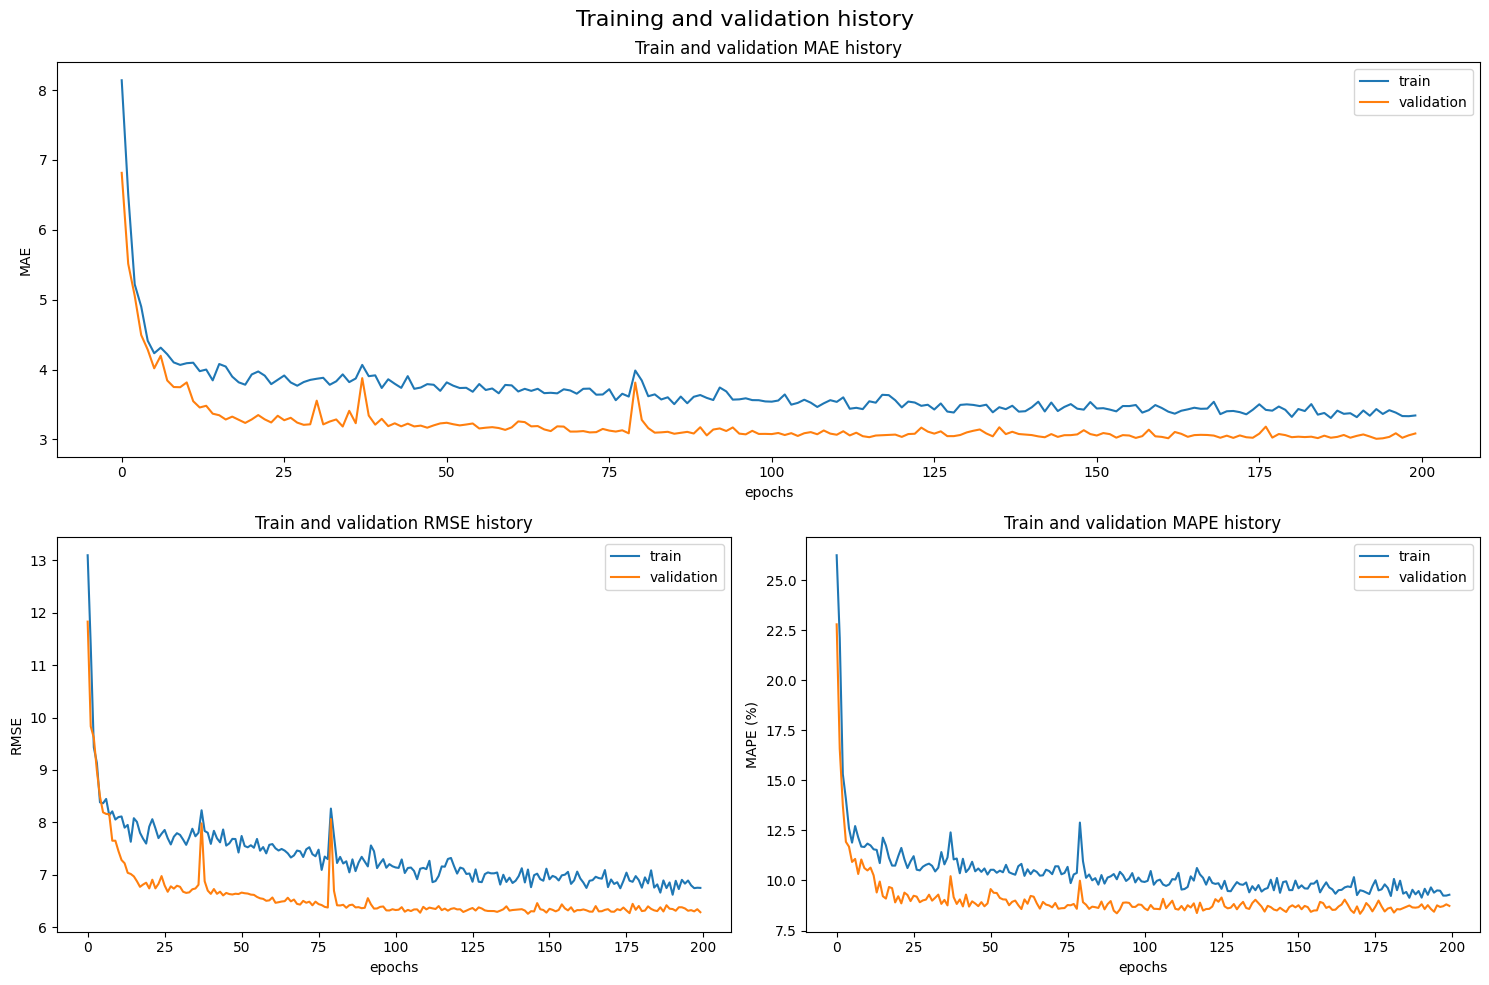

In [89]:
from src.spatial_temporal_gnn.training import plot_training_history

plot_training_history(history)

# 3 Evaluation and Error Analysis
The model is finally evaluated on the test dataset and a brief error analysis is performed.

The trained model is evaluated on the test dataset, considering the error results on predictions of the next $15$, $30$ and $60$ minutes.

As expected, predictions of closer events in term of time lead to lower errors.

In [90]:
from src.spatial_temporal_gnn.training import validate

test_mae_15_min, test_rmse_15_min, test_mape_15_min = validate(
    model, test_dataloader, scaler,
    DEVICE, 3)
print('Results on the test set considering the next 15 minutes:',
      f'MAE {test_mae_15_min:.3g} - RMSE {test_rmse_15_min:.3g}',
      f'- MAPE {test_mape_15_min * 100.:.3g} %')

test_mae_30_min, test_rmse_30_min, test_mape_30_min = validate(
    model, test_dataloader, scaler,
    DEVICE, 6)
print('Results on the test set considering the next 30 minutes:',
      f'MAE {test_mae_30_min:.3g} - RMSE {test_rmse_30_min:.3g}',
      f'- MAPE {test_mape_30_min * 100.:.3g} %')

test_mae_60_min, test_rmse_60_min, test_mape_60_min = validate(
    model, test_dataloader, scaler,
    DEVICE)
print('Results on the test set considering the next 60 minutes:',
      f'MAE {test_mae_60_min:.3g} - RMSE {test_rmse_60_min:.3g}',
      f'- MAPE {test_mape_60_min * 100.:.3g} %')

Results on the test set considering the next 15 minutes: MAE 2.83 - RMSE 5.35 - MAPE 7.43 %
Results on the test set considering the next 30 minutes: MAE 3.17 - RMSE 6.23 - MAPE 8.62 %
Results on the test set considering the next 60 minutes: MAE 3.75 - RMSE 7.5 - MAPE 10.9 %


In [91]:
from src.spatial_temporal_gnn.prediction import (
    get_ground_truth_and_predictions)

y_true, y_pred = get_ground_truth_and_predictions(
    model, test_dataloader, DEVICE, scaler, use_standardized_scale=False)

The next plot represents the comparison of ground truth speeds and predicted speeds in the test dataset for a series of randomly selected nodes and timestamps. We can observe that the model performs quite well, although some speed peaks and troughs are hardly predicted correctly.

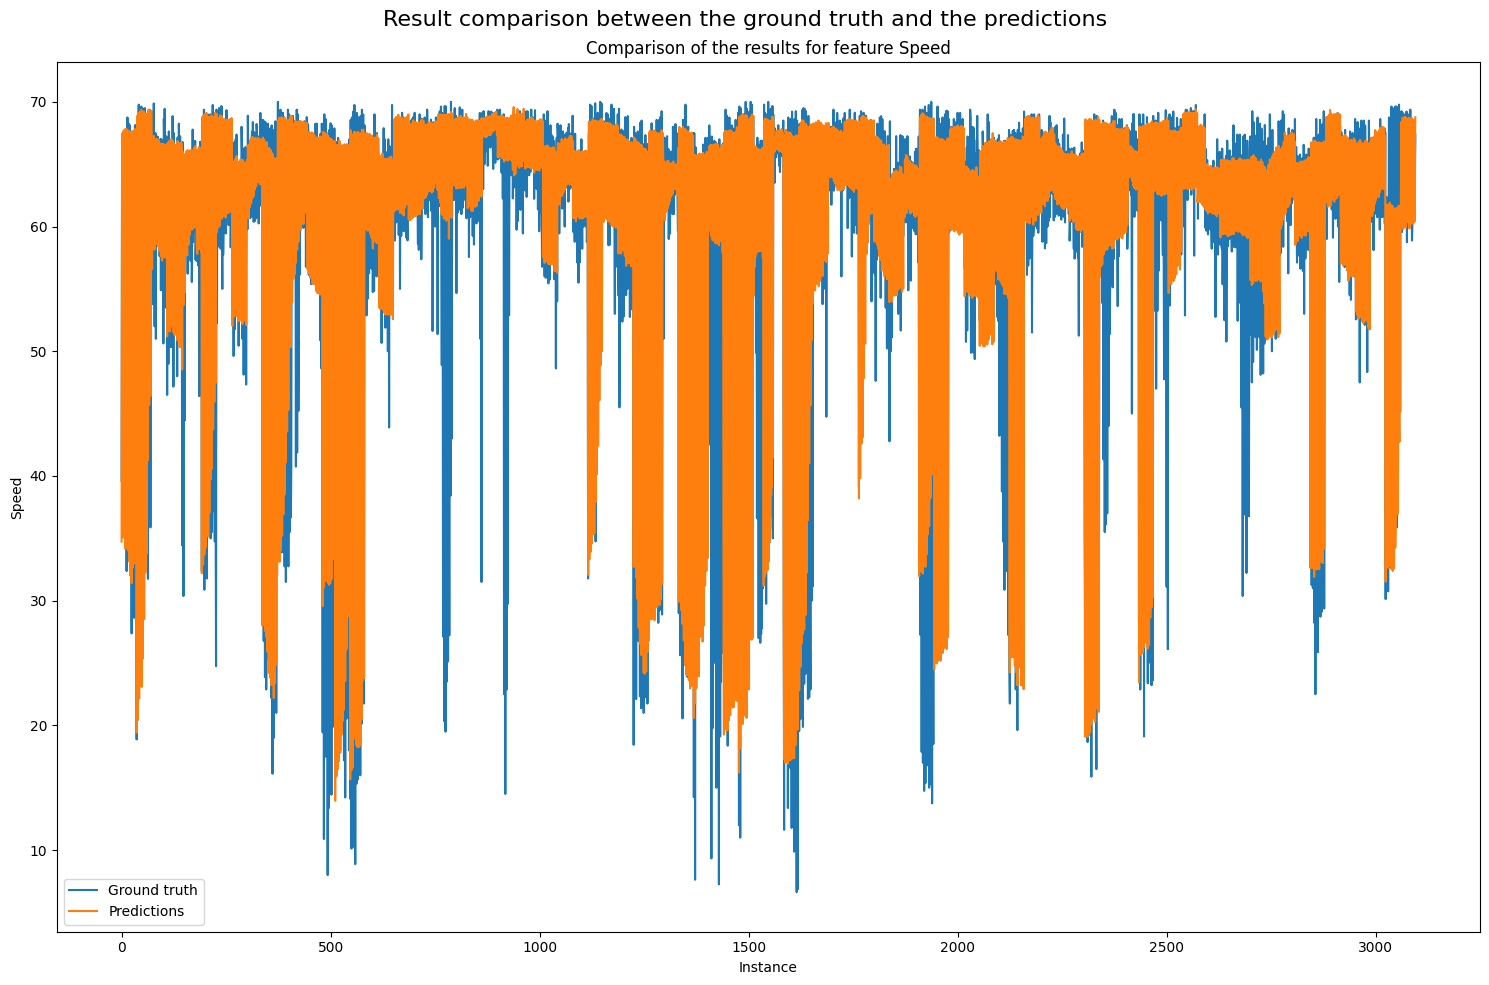

In [92]:
from src.spatial_temporal_gnn.prediction import plot_results_comparison

plot_results_comparison(y_true, y_pred, ['Speed'])

Finally, we observe the scatter plot represents the fitness of ground truth speeds and predicted speeds in the test dataset for a series of randomly selected nodes and timestamps.

It looks like that the error variation for higher speed nodes is higher than for slower speed ones. This is expected as the distribution of speed in the dataset is particularly left skewed.

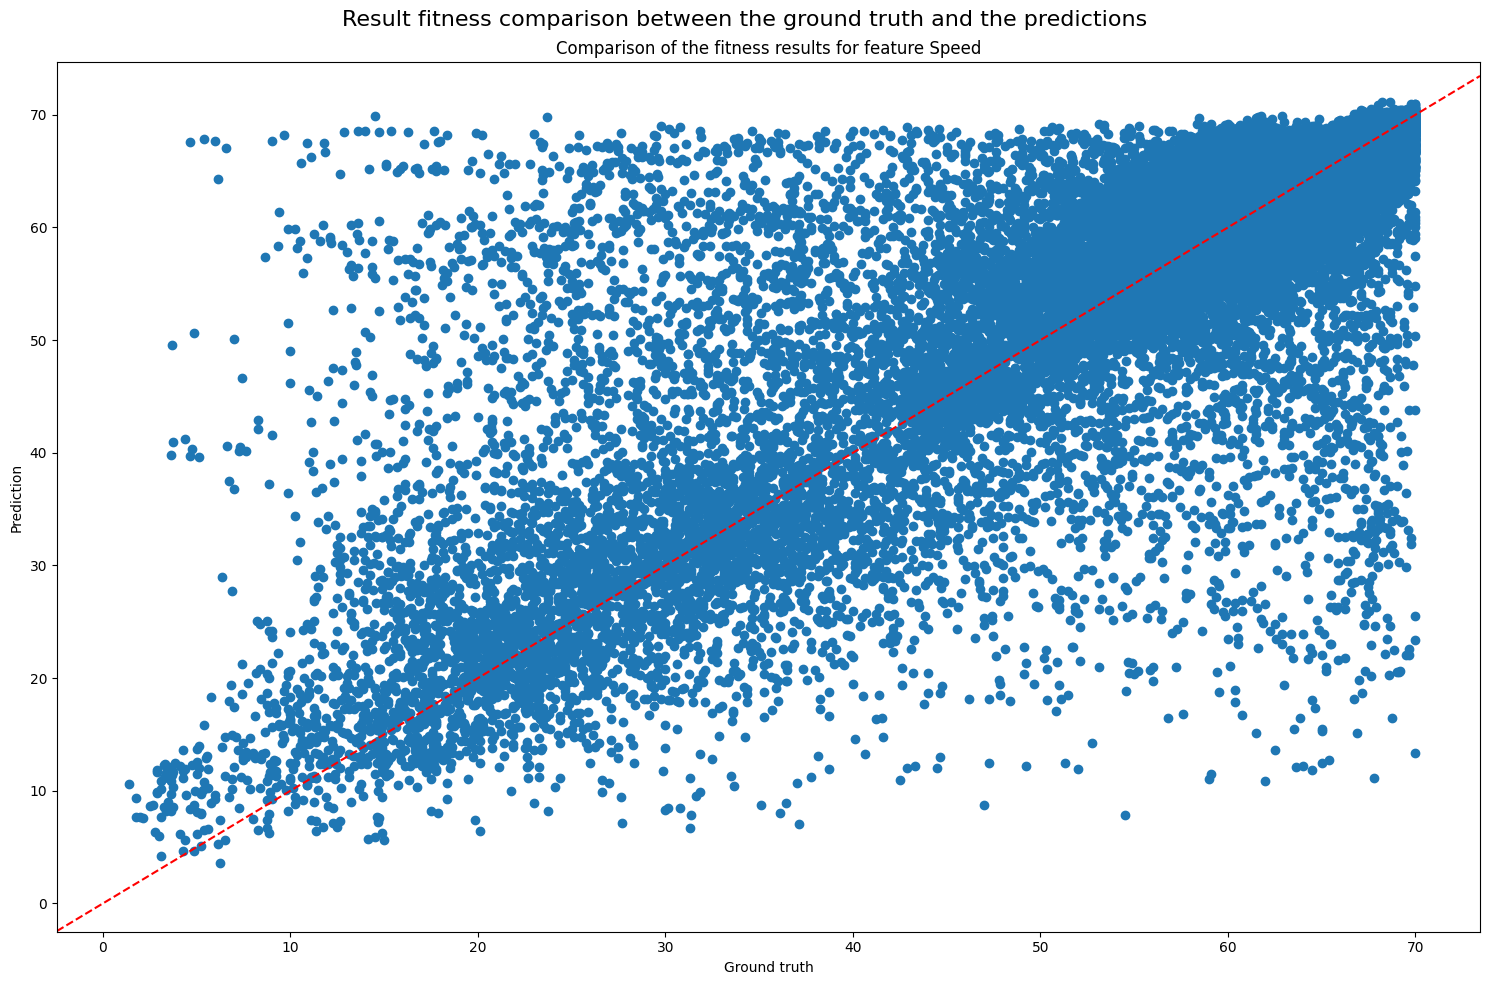

In [93]:
from src.spatial_temporal_gnn.prediction import plot_results_fitness

plot_results_fitness(y_true, y_pred, ['Speed'])